# Mesure de la performance du modèle

L'objet de ce notebook est d'illustrer la méthodologie de mesure de la performance du modèle.


## Préambule technique

In [1]:
# setting up sys.path for relative imports
from pathlib import Path
import sys
project_root = str(Path(sys.path[0]).parents[1].absolute())
if project_root not in sys.path:
    sys.path.append(project_root)

In [52]:
# imports and customization of diplay
import os
from functools import partial
import numpy as np
from scipy.stats import linregress
import pandas as pd
pd.options.display.min_rows = 6
pd.options.display.width=108
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from src.pimest import ContentGetter
from src.pimest import PathGetter
from src.pimest import PDFContentParser
from src.pimest import BlockSplitter
from src.pimest import SimilaritySelector
from src.pimest import custom_accuracy
from src.pimest import text_sim_score
from src.pimest import text_similarity
from src.pimest import build_text_processor

## Acquisition des données

On récupère les données manuellement étiquetées et on les intègre dans un dataframe

In [3]:
ground_truth_df = pd.read_csv(Path('..') / '..' / 'ground_truth' / 'manually_labelled_ground_truth.csv',
                              sep=';',
                              encoding='latin-1',
                              index_col='uid')
ground_truth_uids = list(ground_truth_df.index)

acqui_pipe = Pipeline([('PathGetter', PathGetter(ground_truth_uids=ground_truth_uids,
                                                  train_set_path=Path('..') / '..' / 'ground_truth',
                                                  ground_truth_path=Path('..') / '..' / 'ground_truth',
                                                  )),
                        ('ContentGetter', ContentGetter(missing_file='to_nan')),
                        ('ContentParser', PDFContentParser(none_content='to_empty')),
                       ],
                       verbose=True)

texts_df = acqui_pipe.fit_transform(ground_truth_df)
texts_df['ingredients'] = texts_df['ingredients'].fillna('')
texts_df

[Pipeline] ........ (step 1 of 3) Processing PathGetter, total=   0.1s
[Pipeline] ..... (step 2 of 3) Processing ContentGetter, total=   0.1s
Launching 8 processes.
[Pipeline] ..... (step 3 of 3) Processing ContentParser, total=  37.5s


,designation,ingredients,path,content,text
uid,,,,,
a0492df6-9c76-4303-8813-65ec5ccbfa70,Concentré liquide Asian en bouteille 980 ml CHEF,"Eau, maltodextrine, sel, arômes, sucre, arôme ...",../../ground_truth/a0492df6-9c76-4303-8813-65e...,b'%PDF-1.5\r\n%\xb5\xb5\xb5\xb5\r\n1 0 obj\r\n...,Concentré Liquide Asian CHEF® \n\nBouteille de...
d183e914-db2f-4e2f-863a-a3b2d054c0b8,Pain burger curry 80 g CREATIV BURGER,"Farine de blé T65, eau, levure, vinaigre de ci...",../../ground_truth/d183e914-db2f-4e2f-863a-a3b...,b'%PDF-1.5\r%\xe2\xe3\xcf\xd3\r\n4 0 obj\r<</L...,
ab48a1ed-7a3d-4686-bb6d-ab4f367cada8,Macaroni en sachet 500 g PANZANI,- 100% Semoule de BLE dur de qualité supérieur...,../../ground_truth/ab48a1ed-7a3d-4686-bb6d-ab4...,b'%PDF-1.4\n%\xc7\xec\x8f\xa2\n5 0 obj\n<</Len...,Direction Qualité \n\n \n\n \n\nPATES ALIMENTA...
...,...,...,...,...,...
e67341d8-350f-46f4-9154-4dbbb8035621,PRÉPARATION POUR CRÈME BRÛLÉE BIO 6L,"Sucre roux de canne*° (64%), amidon de maïs*, ...",../../ground_truth/e67341d8-350f-46f4-9154-4db...,b'%PDF-1.7\r\n%\xb5\xb5\xb5\xb5\r\n1 0 obj\r\n...,FICHE TECHNIQUE \n\nCREME BRÛLÉE 6L \n\nREF : ...
a8f6f672-20ac-4ff8-a8f2-3bc4306c8df3,Céréales instantanées en poudre saveur caramel...,"Farine 87,1 % (Blé (GLUTEN), Blé hydrolysé (GL...",../../ground_truth/a8f6f672-20ac-4ff8-a8f2-3bc...,b'%PDF-1.5\r\n%\xb5\xb5\xb5\xb5\r\n1 0 obj\r\n...,81 rue de Sans Souci – CS13754 – 69576 Limones...
0faad739-ea8c-4f03-b62e-51ee592a0546,"FARINE DE BLÉ TYPE 45, 10KG",Farine de blé T45,../../ground_truth/0faad739-ea8c-4f03-b62e-51e...,b'%PDF-1.5\r\n%\xb5\xb5\xb5\xb5\r\n1 0 obj\r\n...,\n1050/10502066400 \n\n10502055300/1050202520...


On splitte les textes en blocs de manière basique.

In [4]:
def splitter(text):
    return(text.split('\n\n'))

split_transfo = BlockSplitter(splitter_func=splitter)
splitted_df = split_transfo.fit_transform(texts_df)
splitted_df

Launching 8 processes.


,designation,ingredients,path,content,text,blocks
uid,,,,,,
a0492df6-9c76-4303-8813-65ec5ccbfa70,Concentré liquide Asian en bouteille 980 ml CHEF,"Eau, maltodextrine, sel, arômes, sucre, arôme ...",../../ground_truth/a0492df6-9c76-4303-8813-65e...,b'%PDF-1.5\r\n%\xb5\xb5\xb5\xb5\r\n1 0 obj\r\n...,Concentré Liquide Asian CHEF® \n\nBouteille de...,"[Concentré Liquide Asian CHEF® , Bouteille de ..."
d183e914-db2f-4e2f-863a-a3b2d054c0b8,Pain burger curry 80 g CREATIV BURGER,"Farine de blé T65, eau, levure, vinaigre de ci...",../../ground_truth/d183e914-db2f-4e2f-863a-a3b...,b'%PDF-1.5\r%\xe2\xe3\xcf\xd3\r\n4 0 obj\r<</L...,,[ ]
ab48a1ed-7a3d-4686-bb6d-ab4f367cada8,Macaroni en sachet 500 g PANZANI,- 100% Semoule de BLE dur de qualité supérieur...,../../ground_truth/ab48a1ed-7a3d-4686-bb6d-ab4...,b'%PDF-1.4\n%\xc7\xec\x8f\xa2\n5 0 obj\n<</Len...,Direction Qualité \n\n \n\n \n\nPATES ALIMENTA...,"[Direction Qualité , , , PATES ALIMENTAIRES ..."
...,...,...,...,...,...,...
e67341d8-350f-46f4-9154-4dbbb8035621,PRÉPARATION POUR CRÈME BRÛLÉE BIO 6L,"Sucre roux de canne*° (64%), amidon de maïs*, ...",../../ground_truth/e67341d8-350f-46f4-9154-4db...,b'%PDF-1.7\r\n%\xb5\xb5\xb5\xb5\r\n1 0 obj\r\n...,FICHE TECHNIQUE \n\nCREME BRÛLÉE 6L \n\nREF : ...,"[FICHE TECHNIQUE , CREME BRÛLÉE 6L , REF : NAP..."
a8f6f672-20ac-4ff8-a8f2-3bc4306c8df3,Céréales instantanées en poudre saveur caramel...,"Farine 87,1 % (Blé (GLUTEN), Blé hydrolysé (GL...",../../ground_truth/a8f6f672-20ac-4ff8-a8f2-3bc...,b'%PDF-1.5\r\n%\xb5\xb5\xb5\xb5\r\n1 0 obj\r\n...,81 rue de Sans Souci – CS13754 – 69576 Limones...,[81 rue de Sans Souci – CS13754 – 69576 Limone...
0faad739-ea8c-4f03-b62e-51ee592a0546,"FARINE DE BLÉ TYPE 45, 10KG",Farine de blé T45,../../ground_truth/0faad739-ea8c-4f03-b62e-51e...,b'%PDF-1.5\r\n%\xb5\xb5\xb5\xb5\r\n1 0 obj\r\n...,\n1050/10502066400 \n\n10502055300/1050202520...,"[ \n1050/10502066400 , 10502055300/10502025200..."


## Train/Test split, entraînement et tranformation

On effectue classiquement les étapes de train/test split, on entraîne le modèle sur le set d'entraînement et on le lance sur le set de test.

In [5]:
train, test = train_test_split(splitted_df, train_size=400, random_state=42)
model = SimilaritySelector(similarity='projection')
model.fit(train['blocks'], train['ingredients'])
predicted = pd.Series(model.predict(test['blocks']),
                      index=test.index,
                      name='predicted'
                     )
predicted = pd.concat([test['ingredients'], predicted], axis=1)
predicted

,ingredients,predicted
uid,,
2892dd68-e3a6-474c-b543-3ebfd3490658,"Café instantané, café torrefié moulu (3%).",- NESTLÉ a un système de management de la qual...
a57c1561-b88e-4694-8bd8-55623f2afa17,Lentilles blondes,Cette fiche technique n’a pas de valeur contra...
3634fb1e-ee79-41d1-8aaa-084c1fae5bd5,"Poire 99,9%, antioxydant: acide ascorbique.",Ce produit est une purée de fruits obtenue à p...
...,...,...
ebfc9e73-5d91-4b45-8331-8c8f9bed3bb3,Jus d'orange à base de concentré,\n \nVALEURS NUTRITIONNELLES pour 100mL / NUT...
c33aa83e-a502-4339-a8e0-c56db2e59e69,"Farine de BLÉ, sucre, huile de colza,, cacao m...","Ingrédients : Farine de BLÉ, sucre, huile de c..."
54f40033-f9cf-411c-81a5-11974f6715aa,"Piment rouge fort équeuté* (85%), cumin, ail m...",A) Ingrédients : \n \nPiment rouge fort équ...


## Mesure de la performance : Précision

### Approche naïve

Dans cette première version, on calculera une précision brute, où seuls les strings parfaitement identiques sont considérés comme ok. 

In [6]:
predicted['result'] = (predicted['ingredients'].fillna('') == predicted['predicted'].fillna(''))
predicted['result'].value_counts()

False    99
True      1
Name: result, dtype: int64

On a une précision très faible, 1%.
L'unique liste d'ingrédients du set de test correctement prédite est la suivante :

In [7]:
print(predicted[predicted['result']].iloc[0, 0])

Sirop de glucose, sucre, eau, stabilisants (E440i, E440ii, E415), acidifiants (E330, E450i), conversateur (E202).


### Cross-validation de l'approche naïve

Pour avoir une vision plus précise de la performance du modèle, on peut effectuer une cross-validation sur le set d'entraînement.

On commence par définir une fonction de scoring, qui pourra être appelée par la fonction standard de cross-validation de scikit-learn. Comme précédemment, il s'agit d'une fonction d'accuracy basique :

In [8]:
def accuracy_scorer(estim, X, y):
    y_pred = estim.predict(X)
    return((y_pred == y).mean())

On retrouve évidemment le même score que précédemment lorsqu'on utilise cette fonction sur le set de test : 

In [9]:
accuracy_scorer(model, test.reset_index()['blocks'], test.reset_index()['ingredients'])

0.01

Si on lance la cross-validation avec les paramètres par défaut (cv=5), on obtient le résultat suivant :

In [10]:
X = splitted_df.reset_index()['blocks'].copy()
y = splitted_df.reset_index()['ingredients'].copy()

cross_val = cross_validate(model,
                           X=X,
                           y=y,
                           scoring=accuracy_scorer,
                          )
print(f'Strict accuracy yields a result of {np.mean(cross_val["test_score"]):.2%} +/-{np.std(cross_val["test_score"]):.2%}')
print(cross_val['test_score'])

Strict accuracy yields a result of 2.40% +/-0.80%
[0.03 0.03 0.02 0.01 0.03]


On voit que sur chacun des 5 folds (validation sur 400 produits), l'accuracy varie entre 1 et 3%.

Si on trace l'accuracy et la standard deviation pour plusieurs valeurs de cv, on obtient les résultats suivants :

In [11]:
x = [3, 5, 8, 10, 15, 20, 30, 50, 70, 100]
mean = np.array([])
std = np.array([])
for n_cv in x:
    cross_val = cross_validate(model,
                               X=splitted_df['blocks'],
                               y=splitted_df['ingredients'],
                               scoring=accuracy_scorer, 
                               cv=n_cv,
                              )
    mean = np.append(mean, [np.mean(cross_val['test_score'])], axis=0)
    std = np.append(std, [np.std(cross_val['test_score'])], axis=0)

print('mean:', mean, '\nstandard dev:', std)

mean: [0.02799221 0.024      0.01996928 0.02       0.01996435 0.02
 0.01997549 0.02       0.01989796 0.02      ] 
standard dev: [0.01015903 0.008      0.01540306 0.02       0.01774134 0.02966479
 0.03208843 0.04472136 0.04881456 0.06      ]


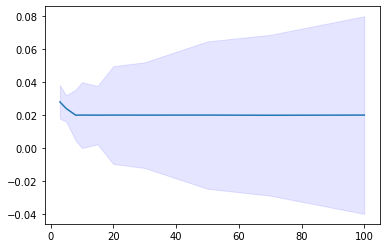

In [12]:
fig, ax = plt.subplots()
ax.plot(x, mean)
ax.fill_between(x, (mean - std), (mean + std), color='b', alpha=.1)

Il apparaît que l'accuracy se situe aux alentours de 2%, avec un écart type important si on le compare à cette accuracy.

In [13]:
cross_val = cross_validate(model,
                           X=splitted_df['blocks'],
                           y=splitted_df['ingredients'],
                           scoring=accuracy_scorer,
                           cv=10,
                          )
print(f'Strict accuracy yields a result of {np.mean(cross_val["test_score"]):.2%} +/-{np.std(cross_val["test_score"]):.2%}')
print(cross_val['test_score'])

Strict accuracy yields a result of 2.00% +/-2.00%
[0.04 0.   0.   0.06 0.02 0.02 0.   0.02 0.   0.04]


### Ajout d'une étape de text-postprocessing

On utilise la fonction `custom_accuracy` définie dans le module pimest pour calculer l'accuracy avec du text processing.
Elle prend en paramètre les mêmes attributs que le `CountVectorizer` de scikit-learn, en plus d'un attribut "tokenize" qui va tokenizer le résultat (pour prise en compte des whitespace et de la ponctuation).

In [16]:
custom_accuracy(model, 
                test['blocks'].fillna(''),
                test['ingredients'].fillna(''),
                tokenize=True,
                strip_accents='unicode',
                lowercase=True,
               )

0.14

L'accuracy est maintenant estimée à 14% (vs. 1%) sur le set de test, après entraînenemt sur le set d'entraînement.

On peut manuellement inspecter les blocks identique, en reproduisant le comportement de la fonction d'accuracy : 

In [17]:
def text_processor(text, **kwargs):
    unused_model = CountVectorizer(**kwargs)
    prepro = unused_model.build_preprocessor()
    token = unused_model.build_tokenizer()    
    return(' '.join(token(prepro(text))))

partial_processor = partial(text_processor, strip_accents='unicode', lowercase=True)

In [18]:
prediction = model.predict(test['blocks'].fillna('')).rename('predicted')
processed_prediction = prediction.apply(partial_processor)
processed_prediction.head(3)

uid
2892dd68-e3a6-474c-b543-3ebfd3490658    nestle un systeme de management de la qualite ...
a57c1561-b88e-4694-8bd8-55623f2afa17    cette fiche technique pas de valeur contractue...
3634fb1e-ee79-41d1-8aaa-084c1fae5bd5    ce produit est une puree de fruits obtenue par...
Name: predicted, dtype: object

In [19]:
processed_ground_truth = test['ingredients'].fillna('').apply(partial_processor)
processed_ground_truth.head(3)

uid
2892dd68-e3a6-474c-b543-3ebfd3490658      cafe instantane cafe torrefie moulu
a57c1561-b88e-4694-8bd8-55623f2afa17                        lentilles blondes
3634fb1e-ee79-41d1-8aaa-084c1fae5bd5    poire 99 antioxydant acide ascorbique
Name: ingredients, dtype: object

In [20]:
corrects = test.join(prediction).loc[processed_prediction == processed_ground_truth , ['ingredients', 'predicted']]
corrects

,ingredients,predicted
uid,,
345591f4-d887-4ddc-bb40-21337fa9269d,"Gésier de dinde émincé 50%, graisse de canard ...","Gésier de dinde émincé 50%, graisse de canard..."
13980d31-9002-457d-8d49-b451f08f473c,"Edulcorants sorbitol, isomalt, sirop de maltit...","Edulcorants sorbitol, isomalt, sirop de maltit..."
c3b6b4df-e586-4f10-8e58-15fbf0816acb,"mini poivrons jaunes, eau, sucre, sel, affermi...","mini poivrons jaunes, eau, sucre, sel, affermi..."
0481d91b-9653-42e7-b525-9dc9b87b06f2,"Farine de BLE, huile de colza non hydrogénée, ...","Farine de BLE, huile de colza non hydrogénée, ..."
484ac00a-a670-46a9-a9c4-5114174d9e3b,"Pommes de terre 59,5 % - Céleris 40 % - Amidon...","Pommes de terre 59,5 % - Céleris 40 % - Amidon..."
49b11281-34ea-44b0-a11c-4ae21d4c58e3,,
d59d96cb-0230-4090-8220-78ce8496fd91,Amidon de maïs* - Lait écrémé* - Sel - Fécule ...,Amidon de maïs* - Lait écrémé* - Sel - Fécule ...
b8cbe6f9-71d4-4e51-a169-1c163d49a561,"Farine de FROMENT, poudre de LACTOSERUM, sucre...","Farine de FROMENT, poudre de LACTOSERUM, sucre..."
a0492df6-9c76-4303-8813-65ec5ccbfa70,"Eau, maltodextrine, sel, arômes, sucre, arôme ...","Eau, maltodextrine, sel, arômes, sucre, arôme ..."


In [21]:
with pd.option_context("max_colwidth", 100000):
    tex_str = (
    corrects.replace(r'^\s*$', np.nan, regex=True)
            .to_latex(index=False,
                      index_names=False,
                      column_format='p{7cm}p{7cm}',
                      na_rep='<rien>',
                      longtable=False,
                      header=["Liste d'ingrédients cible", "Liste d'ingrédients prédite"],
                      # label='tbl:GT_postprocessed_corrects',
                      # caption="Prédictions identifiées comme correctes après postprocessing",
                  )
             .replace(r'\textbackslash n', r' \newline ')
             .replace(r'\\', r'\\ \hline')
    )
    
# with open(Path('..') / 'tbls' / 'GT_postprocessed_corrects.tex', 'w') as file:
#     file.write(tex_str)

### Cross-validation de l'approche avec text processing

On fait tourner une cross-validation sur l'ensemble du dataset. 
On définit d'abord la fonction qui va permettre de calculer le score avec l'ensemble des fonctionnalités de text processing : 
- retrait des accents
- remplacement des whitespaces par des espaces simples
- retrait de la ponctution
- mise en minuscule

In [22]:
processed_accuracy = partial(custom_accuracy,
                             tokenize=True,
                             strip_accents='unicode',
                             lowercase=True,
                            )
cross_val = cross_validate(model,
                           X=splitted_df['blocks'].fillna(''),
                           y=splitted_df['ingredients'].fillna(''),
                           scoring=processed_accuracy,
                          )
print(f'Processed accuracy yields a result of {np.mean(cross_val["test_score"]):.2%} +/-{np.std(cross_val["test_score"]):.2%}')
print(cross_val['test_score'])

Processed accuracy yields a result of 17.00% +/-2.45%
[0.2  0.16 0.17 0.13 0.19]


In [23]:
x = [3, 5, 8, 10, 15, 20, 30, 50, 70, 100]
mean = np.array([])
std = np.array([])
for n_cv in x:
    cross_val = cross_validate(model,
                               X=splitted_df['blocks'].fillna(''),
                               y=splitted_df['ingredients'].fillna(''),
                               scoring=processed_accuracy, 
                               cv=n_cv,
                              )
    mean = np.append(mean, [np.mean(cross_val['test_score'])], axis=0)
    std = np.append(std, [np.std(cross_val['test_score'])], axis=0)

print('mean:', mean, '\nstandard dev:', std)

mean: [0.17593728 0.17       0.16599462 0.166      0.16387403 0.162
 0.16372549 0.162      0.16173469 0.162     ] 
standard dev: [0.02658629 0.0244949  0.03903199 0.03352611 0.06445016 0.07947327
 0.09572828 0.12472369 0.13735865 0.16418282]


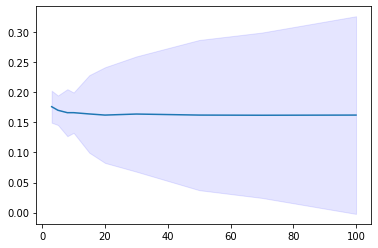

In [24]:
fig, ax = plt.subplots()
ax.plot(x, mean)
ax.fill_between(x, (mean - std), (mean + std), color='b', alpha=.1)

In [25]:
cross_val = cross_validate(model,
                           X=splitted_df['blocks'].fillna(''),
                           y=splitted_df['ingredients'].fillna(''),
                           scoring=processed_accuracy,
                           cv=10,
                          )
print(f'Processed accuracy yields a result of {np.mean(cross_val["test_score"]):.2%} +/-{np.std(cross_val["test_score"]):.2%}')
print(cross_val['test_score'])

Processed accuracy yields a result of 16.60% +/-3.35%
[0.2  0.18 0.18 0.14 0.12 0.22 0.14 0.12 0.16 0.2 ]


## Mesure de la performance : Similarité

### Mesures

On peut également mesurer la similarité plutôt qu'uniquement l'accuracy. Cela permet de valoriser les textes qui "ressemblent" aux listes d'ingrédients cibles plutôt que les compter comme des erreurs.

In [26]:
similarity_kinds = ['levenshtein',
                    'damerau-levenshtein', 
                    'jaro',
                    'jaro-winkler',
                   ]

sim_dict = dict()

for similarity in similarity_kinds:
    sim = text_sim_score(model, 
                         test['blocks'].fillna(''),
                         test['ingredients'].fillna(''),
                         similarity=similarity,
                        )
    sim_dict[similarity] = f'{sim:.2%}'
    print(f'Similarity with {similarity} similarity is {sim:.2%}')

Similarity with levenshtein similarity is 48.86%
Similarity with damerau-levenshtein similarity is 48.86%
Similarity with jaro similarity is 63.56%
Similarity with jaro-winkler similarity is 65.67%


Les similarités de Levenshtein et Damerau-Levenshtein donnent des résultats identiques, à presque 50% de similarité moyenne. Celles basées sur Jaro tournent aux alentours de 65%, comme on s'y attendait dans la mesure où elle est très "indulgente" sur les textes longs.

Si on effectue des cross validations sur chacune de ces distances sur le dataset complet, on obtient :

In [27]:
similarities = {similarity: partial(text_sim_score, similarity=similarity) for similarity in similarity_kinds}

cross_vals = dict()

for similarity in similarity_kinds:
    cross_vals[similarity] = cross_validate(model, 
                                            splitted_df['blocks'].fillna(''),
                                            splitted_df['ingredients'].fillna(''),
                                            scoring=similarities[similarity],
                                            cv=10,
                                            )
for similarity in similarity_kinds:
    print(f'Model evaluated with {similarity} similarity a result of '
          f'{np.mean(cross_vals[similarity]["test_score"]):.2%} '
          f'+/-{np.std(cross_vals[similarity]["test_score"]):.2%}')

Model evaluated with levenshtein similarity a result of 49.79% +/-3.73%
Model evaluated with damerau-levenshtein similarity a result of 49.80% +/-3.72%
Model evaluated with jaro similarity a result of 62.78% +/-3.28%
Model evaluated with jaro-winkler similarity a result of 64.40% +/-3.50%


On transforme en tableau latex pour insertion dans le rapport.

In [28]:
result_strings = dict()

for similarity in similarity_kinds:
    result_strings[similarity] = {'train/test set': sim_dict[similarity], 
                                  'cross validation': f'{np.mean(cross_vals[similarity]["test_score"]):.2%} '
                                                      f'+/-{np.std(cross_vals[similarity]["test_score"]):.2%}'}
result_df = pd.DataFrame(result_strings).T
print(result_strings)
labs = {'levenshtein': 'Levenshtein',
        'damerau-levenshtein': 'Damerau-Levenshtein',
        'jaro': 'Jaro',
        'jaro-winkler': 'Jaro-Winkler',
       }
# (result_df.rename(labs)
#           .to_latex(Path('..') / 'tbls' / 'similarities_result.tex',
#                    column_format='lcc',
#                    bold_rows=True,
#                   )
# )

{'levenshtein': {'train/test set': '48.86%', 'cross validation': '49.79% +/-3.73%'}, 'damerau-levenshtein': {'train/test set': '48.86%', 'cross validation': '49.80% +/-3.72%'}, 'jaro': {'train/test set': '63.56%', 'cross validation': '62.78% +/-3.28%'}, 'jaro-winkler': {'train/test set': '65.67%', 'cross validation': '64.40% +/-3.50%'}}


### Illustration

On illustre les différents niveaux de similarité sur le set de test après entrainement sur le set d'entrainement.

In [29]:
# building the dataframe
y_pred = model.predict(test['blocks']).rename('predicted')
comp_df = pd.concat([test['ingredients'].fillna(''), y_pred], axis=1)
processed_df = comp_df.applymap(build_text_processor())

# computing similarities and ranks
sim_funcs = {sim: partial(text_similarity, similarity=sim) for sim in similarity_kinds}
for sim in similarity_kinds:
    processed_df[sim] = processed_df.apply(lambda x: sim_funcs[sim](x['ingredients'], x['predicted']), axis=1)
    processed_df[sim + '_rank'] = processed_df[sim].rank(axis=0, method='first', ascending=False)

In [30]:
(processed_df.join(comp_df, lsuffix='_')
             .sort_values(['levenshtein'], ascending=False)
             .loc[(processed_df['ingredients'] != '') & (processed_df['predicted'] != '')]
)

,ingredients_,predicted_,levenshtein,levenshtein_rank,damerau-levenshtein,damerau-levenshtein_rank,jaro,jaro_rank,jaro-winkler,jaro-winkler_rank,ingredients,predicted
uid,,,,,,,,,,,,
b8cbe6f9-71d4-4e51-a169-1c163d49a561,farine de froment poudre de lactoserum sucre p...,farine de froment poudre de lactoserum sucre p...,1.000000,8.0,1.000000,8.0,1.000000,8.0,1.000000,11.0,"Farine de FROMENT, poudre de LACTOSERUM, sucre...","Farine de FROMENT, poudre de LACTOSERUM, sucre..."
dc536305-82fd-4afe-a472-5056ca0e21ea,legumes 43 pomme de terre oignon carotte tomat...,legumes 43 pomme de terre oignon carotte tomat...,1.000000,14.0,1.000000,14.0,1.000000,14.0,1.000000,25.0,"Légumes 43,2 % (pomme de terre, oignon, carott...","Légumes 43,2 % (pomme de terre, oignon, carott..."
63968dc3-6e7c-4056-bd53-820c6cc925be,carottes eau sucre sel vinaigre alcool acidifi...,carottes eau sucre sel vinaigre alcool acidifi...,1.000000,13.0,1.000000,13.0,1.000000,13.0,1.000000,24.0,"Carottes, eau, sucre, sel, vinaigre d'alcool, ...","Carottes, eau, sucre, sel, vinaigre d’alcool, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
bb77c7b0-9c63-4869-9ab1-823ba1158f53,tilleul 100,dans le cadre des recommandations de sante pub...,0.019185,89.0,0.019185,89.0,0.259974,91.0,0.259974,91.0,Tilleul (100%).,Dans le cadre des recommandations de santé pub...
6267b9f8-2529-4bc6-ba4b-26760f0522b3,eau gazeifiee colorant e150d acidifiants acide...,coca cola light mini 150 mlean5449000239808mar...,0.012461,90.0,0.012461,90.0,0.506069,74.0,0.506069,74.0,eau gazéifiée\ncolorant : E150d\nacidifiants :...,Coca­Cola Light mini 8 x 150 mlEAN544900023980...
2ca5dc9e-8058-499a-affe-3ec9c06d55b7,100 arabica,gammemarqueargumentation commercialepreparatio...,0.011411,91.0,0.011411,91.0,0.372595,89.0,0.372595,89.0,100% Arabica,gammemarqueargumentation commercialepreparatio...


In [31]:
# outputing to latex
with pd.option_context("max_colwidth", 100000):
    tex_str = (processed_df.sort_values('levenshtein_rank')
                           .loc[(processed_df['ingredients'] != '') &
                                (processed_df['predicted'] != '') &
                                (processed_df['predicted'].apply(len) <=300)]
                           .join(comp_df, lsuffix='_')
                           .iloc[np.r_[0:3, 50:53, -3:0]]
                           .to_latex(columns=['ingredients', 'predicted', 'levenshtein', 'levenshtein_rank',
                                              'damerau-levenshtein', 'jaro', 
                                              'jaro-winkler'],
                                     index=False,
                                     index_names=False,
                                     column_format='p{5cm}p{5cm}cccccccc',
                                     formatters={'levenshtein': lambda x: f'{x:.2%}', 
                                                 'levenshtein_rank': lambda x: f'{x:1.0f}',
                                                 'damerau-levenshtein': lambda x: f'{x:.2%}', 
                                                 #'damerau-levenshtein_rank': lambda x: f'{x:1.0f}',
                                                 'jaro': lambda x: f'{x:.2%}',
                                                 #'jaro_rank': lambda x: f'{x:1.0f}',
                                                 'jaro-winkler': lambda x: f'{x:.2%}',
                                                 #'jaro-winkler_rank': lambda x: f'{x:1.0f}',
                                                },
                                     header=["Listes d'ingrédients cibles", "Listes d'ingrédients prédites",
                                             'Lev', 'rang', 'Dam-Lev', 'Jaro', 'Jaro-Win'],
                                     na_rep = '<rien>',
                                    )
    ).replace(r'\textbackslash n', r' \newline ').replace(r'\\', r'\\ \hline')
    
# with open(Path('..') / 'tbls' / 'similarity_illustration.tex' , 'w') as file:
#     file.write(tex_str)


## Similarité vs. longueur des listes d'ingrédients

On compare le score de similarité obtenu par rapport à la longueur des listes d'ingrédients cibles.

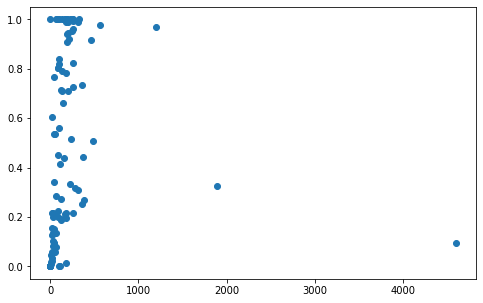

In [60]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(y=processed_df['levenshtein'], x=processed_df['ingredients'].apply(len))

On a des outliers qui vont avoir trop d'importance sur les résultats. On va les filtrer.

In [75]:
filtered = processed_df.loc[processed_df['ingredients'].apply(len) <= 350]

In [81]:
linregress(x=filtered['ingredients'].apply(len), y=filtered['levenshtein']).rvalue ** 2

0.34026294846691624

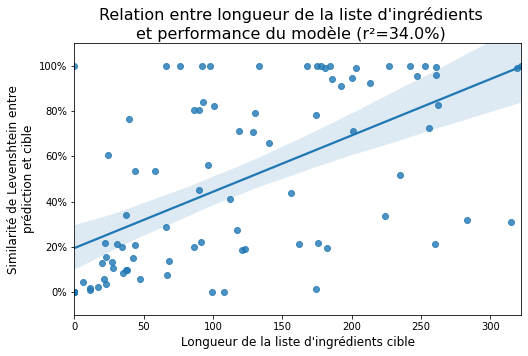

In [82]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.regplot(x=filtered['ingredients'].apply(len), y=filtered['levenshtein'], ax=ax)
ax.set_xlabel("Longueur de la liste d'ingrédients cible", fontsize=12)
ax.set_ylabel("Similarité de Levenshtein entre\nprédiction et cible", fontsize=12)
fig.suptitle("Relation entre longueur de la liste d'ingrédients\net performance du modèle (r²=34.0%)", fontsize=16)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.))
ax.set_ylim(-0.1, 1.1)
fig.savefig(Path('..') / 'img' / 'perf_vs_length.png', bbox_inches='tight')